In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

In [3]:
df = pd.read_csv('SeoulBikeData.csv')
df.head()

,Date,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01-12-2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01-12-2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01-12-2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01-12-2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01-12-2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [4]:
# Dropped some columns
df = df.drop(['Date', 'Holiday', 'Seasons'], axis=1)
df.head()

,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Functioning Day
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Yes
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Yes
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Yes
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Yes
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Yes


In [5]:
# Changing the column names
columns = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]
df.columns = columns
df.head()

,bike_count,hour,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Yes
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Yes
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Yes
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Yes
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Yes


In [6]:
df['functional'] = (df['functional']=='Yes').astype(int)
df.head()

,bike_count,hour,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,1
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,1
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,1
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,1
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,1


In [10]:
# Choosing only data having hour as 12
df = df[df['hour']==12]
df = df.drop('hour', axis=1)
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


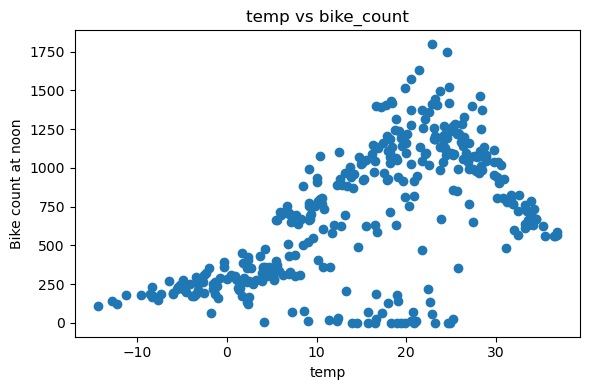

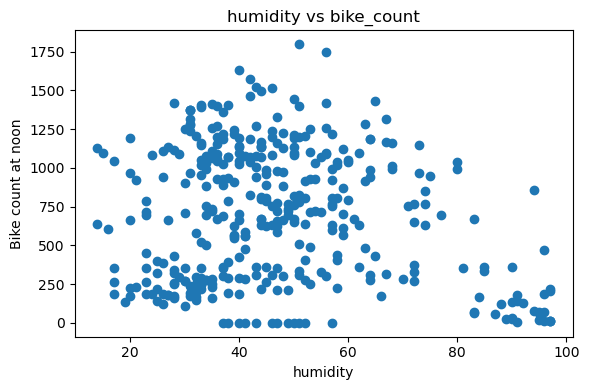

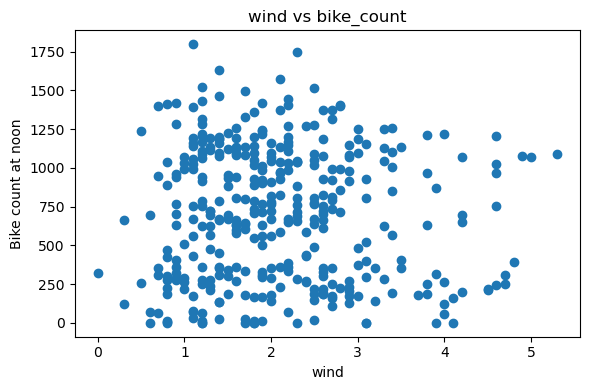

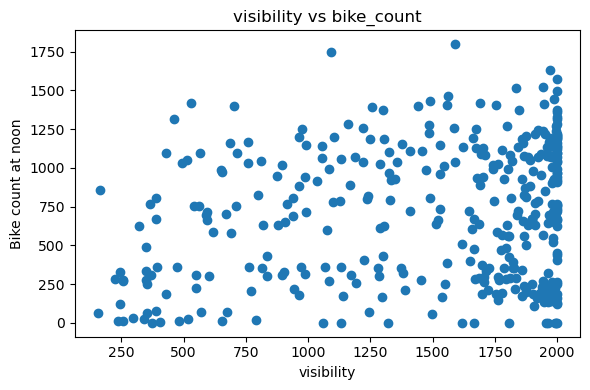

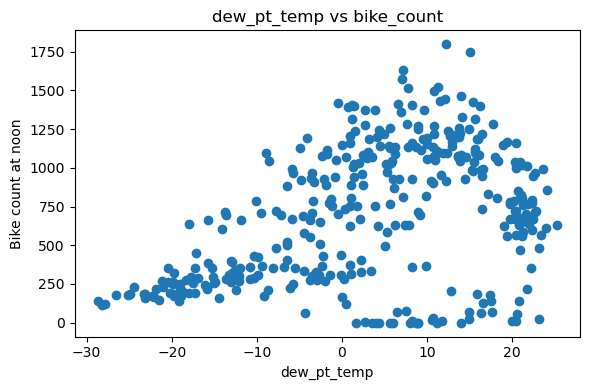

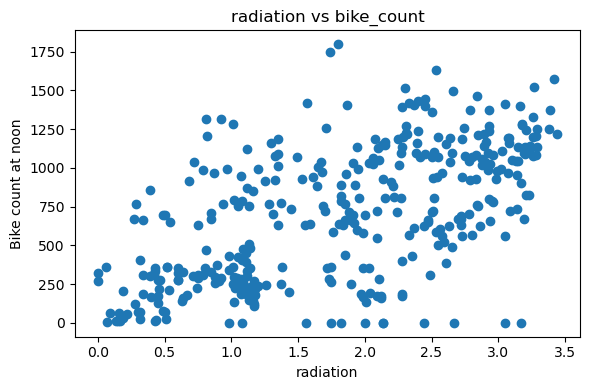

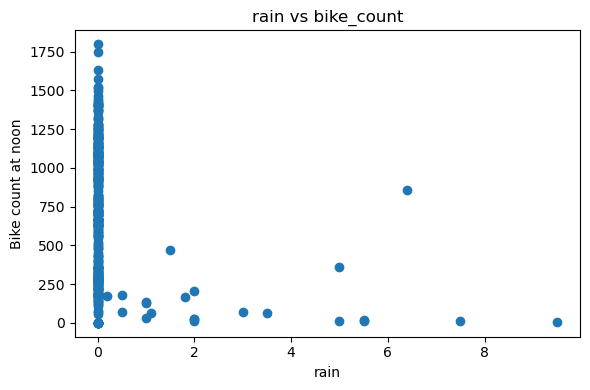

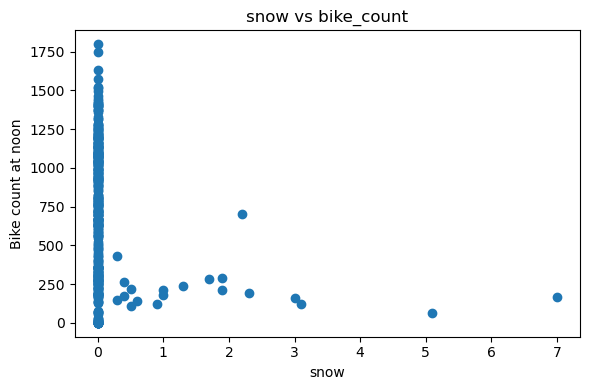

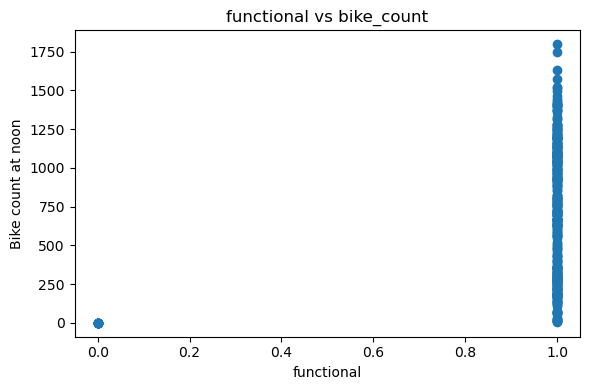

In [11]:
for label in df.columns[1:]:
    plt.figure(figsize=(6, 4))
    plt.scatter(df[label], df['bike_count'])
    plt.title(f'{label} vs bike_count')
    plt.xlabel(label)
    plt.ylabel('Bike count at noon')
    plt.tight_layout()
    plt.show()

In [12]:
df = df.drop(['wind', 'visibility', 'functional'], axis=1)
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


## Train, valid and test

In [21]:
train, valid, test = np.split(df.sample(frac=1).reset_index(drop=True), [int(0.6*len(df)), int(0.8*len(df))])

In [22]:
# Function to filter it out:
def get_xy(dataframe, y_label, x_labels=None):
    dataframe = copy.deepcopy(dataframe)
    if not x_labels:
        X = dataframe[[c for c in dataframe.columns if c!=y_label]].values
    else:
        if len(x_labels) == 1:
            X = dataframe[x_labels[0]].values.reshape(-1, 1)
        else:
            X = dataframe[x_labels].values
    y = dataframe[y_label].values.reshape(-1, 1)
    data = np.hstack((X, y))

    return data, X, y

In [27]:
_, X_train_temp, y_train_temp = get_xy(train, 'bike_count', x_labels=['temp'])
_, X_valid_temp, y_valid_temp = get_xy(valid, 'bike_count', x_labels=['temp'])
_, X_test_temp, y_test_temp = get_xy(test, 'bike_count', x_labels=['temp'])

In [28]:
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)

LinearRegression()

In [32]:
# y = mx + c
# m -> coef_, c -> intercept, score -> R² (R-squared) metric:
# R² = 1 - (Residual Sum of Squares / Total Sum of Squares)
print(temp_reg.coef_, temp_reg.intercept_)
print(temp_reg.score(X_test_temp, y_test_temp))

[[21.56906426]] [374.58529494]
0.3250253421078678


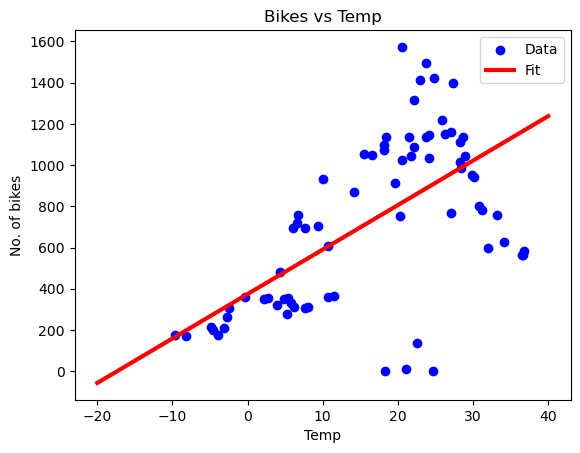

In [39]:
# Plotting and visualizing
plt.scatter(X_train_temp, y_train_temp, label='Data', color='blue')
x = np.linspace(-20,40,100).reshape(-1,1)
plt.plot(x, temp_reg.predict(x), label='Fit', color='red', linewidth=3)
plt.legend()
plt.xlabel('Temp')
plt.ylabel('No. of bikes')
plt.title('Bikes vs Temp')
plt.show()

## Multiple Linear Regression